In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import sklearn as sk
import cv2
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

## IMPORTING DATA FROM MY GOOGLE DRIVE

In [ ]:
# MOUNTING THE DRIVE
from google.colab import drive

drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Data/public/')

# LOADING DATASET FROM CSV
dataset = pd.read_csv('public.csv')

# REPLACING IMAGE FILENAME WITH PATH
for i in range(0, 5758):
  if dataset['ground truth'][i] == 1:
    dataset['name'][i] = 'globally_sclerotic_glomeruli/' + dataset['name'][i]
  else:
    dataset['name'][i] = 'non_globally_sclerotic_glomeruli/' + dataset['name'][i]

## PREPROCESSING THE DATA

In [6]:
# CREATE INDEPENDENT VARIABLE SET (IMAGE FILE PATH) AND DEPENDENT VARIABLE SET (LABEL)
X = dataset.drop('ground truth', axis = 1)
y = dataset['ground truth']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, random_state = 42)

y_test = pd.DataFrame(y_test)
y_val = pd.DataFrame(y_val)
y_train = pd.DataFrame(y_train)

In [8]:
def preprocess_images_by_color(X, y, path):
  for i in X.index: # len(X.index) GIVES NO.OF ROWS IN DATAFRAME X
    img = cv2.imread(X['name'][i])

    img_processed = cv2.resize(img, (224, 224)) # FOR ResNet50

    # APPLYING COLOR ENHANCEMENTS
    # EQUALIZED HISTOGRAM
    img_yuv = cv2.cvtColor((img_processed * 255).astype(np.uint8), cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_processed = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # CONVERT TO FLOAT32 FOR FURTHER PROCESSING
    img_processed = img_processed.astype(np.float32)

    # SATURATION AND HUE ENHANCEMENTS
    pil_img = Image.fromarray((img_processed * 255).astype(np.uint8))
    enhancer = ImageEnhance.Color(pil_img)
    pil_img = enhancer.enhance(1.5)  # INCREASED SATURATION BY 1.5 TIMES
    img_processed = np.array(pil_img)

    if y['ground truth'][i] == 1:
      dest_path = os.path.join(path,'sclerotic')
    else:
      dest_path = os.path.join(path, 'non_sclerotic')

    os.makedirs(dest_path, exist_ok=True)


    file_name = os.path.basename(X['name'][i])

    pil_img.save(os.path.join(dest_path, file_name))

# DEFINING BASE DIRECTORY TO STORE FIRST PREPROCESSED DATASET
base_dir = '/content/drive/MyDrive/processed_dataset'
os.makedirs(base_dir, exist_ok = True)

# CREATE TRAIN, VALIDATION, TEST DIRECTORIES
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# CREATE SUBDIRECTOREIS FOR GLOBALLY SCLEROTIC AND NON-GLOBALLY SCLEROTIC
subdirs = ['sclerotic', 'non_sclerotic']
for subdir in subdirs:
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)

# CALL THE PREPROCESSING FUNCTION
preprocess_images_by_color(X_train, y_train, train_dir)
preprocess_images_by_color(X_val, y_val, validation_dir)
preprocess_images_by_color(X_test, y_test, test_dir)

In [9]:
# CREATE THE TENSOR DATASETS WITH BATCH SIZE SET TO 32 FOR FIRST PREPROCESSED DATASET
batch_size = 32
img_size = (224, 224)
train_dataset_1 = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            image_size=img_size)

validation_dataset_1 = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 color_mode='rgb',
                                                                 batch_size=batch_size,
                                                                 image_size=img_size)

test_dataset_1 = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           batch_size=batch_size,
                                                           image_size=img_size)

# PREFETCHING FOR THE DATASET_1
train_dataset_1 = train_dataset_1.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_1 = validation_dataset_1.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_1 = test_dataset_1.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 4159 files belonging to 2 classes.
Found 735 files belonging to 2 classes.
Found 864 files belonging to 2 classes.


In [11]:
import os
import cv2
import numpy as np

def preprocess_images_by_structure(X, y, path):
    for i in X.index:
        img = cv2.imread(X['name'][i])

        img_processed = cv2.resize(img, (299, 299)) # FOR InceptionV3

        # APPLY STRUCTURAL ENHANCEMENTS
        # APPLY DILATION AND EROSION
        kernel = np.ones((3, 3), np.uint8)
        img_processed = cv2.dilate(img_processed, kernel, iterations=1)
        img_processed = cv2.erode(img_processed, kernel, iterations=1)

        # APPLY GAUSSIAN BLUR TO DENOISE
        img_processed = cv2.GaussianBlur(img_processed, (5, 9), 0)

        # EDGE DETECTION USING CANNY
        edges = cv2.Canny(img_processed, 100, 200)
        img_processed = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

        if y['ground truth'][i] == 1:
            dest_path = os.path.join(path, 'sclerotic')
        else:
            dest_path = os.path.join(path, 'non_sclerotic')

        os.makedirs(dest_path, exist_ok=True)

        file_name = os.path.basename(X['name'][i])
        cv2.imwrite(os.path.join(dest_path, file_name), img_processed)

# DEFINING BASE DIRECTORY TO STORE SECOND PREPROCESSED DATASET
base_dir = '/content/drive/MyDrive/processed_dataset_2'
os.makedirs(base_dir, exist_ok=True)

# CREATE TRAIN, VALIDATION, TEST DIRECTORIES
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# CREATE SUBDIRECTOREIS FOR GLOBALLY SCLEROTIC AND NON-GLOBALLY SCLEROTIC
subdirs = ['sclerotic', 'non_sclerotic']
for subdir in subdirs:
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)

# CALL THE PREPROCESSING FUNCTION
preprocess_images_by_structure(X_train, y_train, train_dir)
preprocess_images_by_structure(X_val, y_val, validation_dir)
preprocess_images_by_structure(X_test, y_test, test_dir)

In [12]:
# CREATE THE TENSOR DATASETS WITH BATCH SIZE SET TO 32 FOR SECOND PREPROCESSED DATASET
batch_size = 32
img_size_2 = (299, 299)
train_dataset_2 = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            image_size=img_size_2)

validation_dataset_2 = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 color_mode='rgb',
                                                                 batch_size=batch_size,
                                                                 image_size=img_size_2)

test_dataset_2 = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           color_mode='rgb',
                                                           batch_size=batch_size,
                                                           image_size=img_size_2)

# PREFETCHING FOR THE DATASET_2
train_dataset_2 = train_dataset_2.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_2 = validation_dataset_2.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_2 = test_dataset_2.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 4159 files belonging to 2 classes.
Found 735 files belonging to 2 classes.
Found 864 files belonging to 2 classes.


In [ ]:
# DEFINE DATA AUGUMENTATION PARAMETERS
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.15),
])

# BASE LEARNER MODEL 1 (RESNET50V2 ON DATASET_1)

In [ ]:
# CREATE THE BASE LEARNER 1 MODEL FROM PRETRAINED RESNET50V2
IMG_SHAPE = img_size + (3,)
base_model_1 = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# BASE MODEL ARCHITECTURE SUMMARY
base_model_1.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
# CHECK NO.OF LAYERS IN RESNET50V2
print("Number of layers in the ResNet50V2: ", len(base_model_1.layers))

Number of layers in the ResNet50V2:  190


In [ ]:
# UNFREEZING TOP 50 LAYERS FOR TRAINING (THE MODEL GETS FITTED TO THE DATASET TO TOP 50 LAYERS ONLY)
base_model_1.trainable = True

train_from_layers = 140

for layer in base_model_1.layers[:train_from_layers]:
  layer.trainable = False

base_model_1.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
# DEFINING TOP TWO LAYERS FOR SETTING OUR OUTPUT REQUIREMENTS
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')

# DEFINE ARCHITECTURE OF THE COMPLETE MODEL AFTER AUGUMENTATION AND PREPROCESSING WITH RESPECT TO RESNET50V2
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = base_model_1(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model_1 = tf.keras.Model(inputs, outputs)

# SUMMARY OF THE UPDATED MODEL
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_5 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

In [ ]:
# COMPILING THE MODEL
base_learning_rate = 0.001
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
              )

# SETTING UP CHECKPOINT CALLBACK TO STORE THE BEST PERFORMED MODEL IN EPOCHS
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='run2_best_resnet50V2_model.keras',      # Path where the model will be saved
    monitor='val_loss',            # Metric to monitor
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # Save the entire model
    mode='min',                    # Mode to determine whether the metric should be minimized or maximized
    verbose=1                      # Verbosity mode, 0 or 1
)

# TRAINING THE MODEL
history = model_1.fit(train_dataset_1,
                    epochs=7,
                    validation_data=validation_dataset_1,
                    callbacks=[checkpoint_callback]
                    )

Epoch 1/7
130/130 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8180
Epoch 1: val_loss improved from inf to 0.46121, saving model to run2_best_resnet50V2_model.keras
130/130 [==============================] - 1381s 11s/step - loss: 0.4571 - accuracy: 0.8180 - val_loss: 0.4612 - val_accuracy: 0.7986
Epoch 2/7
130/130 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8192
Epoch 2: val_loss improved from 0.46121 to 0.44260, saving model to run2_best_resnet50V2_model.keras
130/130 [==============================] - 1385s 11s/step - loss: 0.3974 - accuracy: 0.8192 - val_loss: 0.4426 - val_accuracy: 0.8150
Epoch 3/7
130/130 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8192
Epoch 3: val_loss improved from 0.44260 to 0.35862, saving model to run2_best_resnet50V2_model.keras
130/130 [==============================] - 1394s 11s/step - loss: 0.4104 - accuracy: 0.8192 - val_loss: 0.3586 - val_accuracy: 0.8000
Epoch 4/7
130/

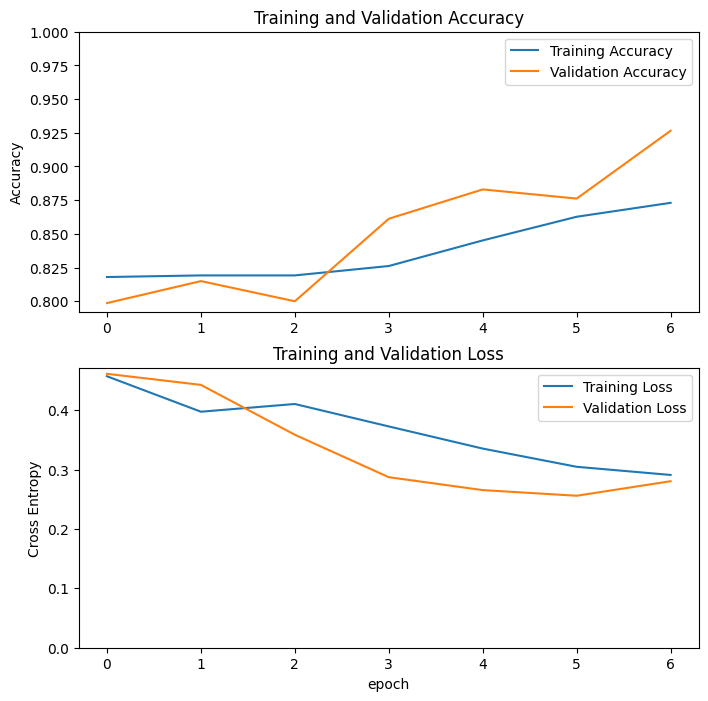

In [ ]:
# PLOTTING THE RESULTS
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# SAVING THE FINAL MODEL (BUT WE'LL USE THE BEST MODEL IDENTIFIED BY CHECKPOINT_CALLBACK)
model_1.save('run2_last_resnet50V2_model.keras')

# BASE LEARNER MODEL 2 (INCEPTIONV3 ON DATASET_2)

In [ ]:
# CREATE THE BASE LEARNER 1 MODEL FROM PRETRAINED RESNET50V2
IMG_SHAPE_2 = img_size_2 + (3,)
base_model_2 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE_2,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# BASE MODEL ARCHITECTURE SUMMARY
base_model_2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
# CHECK NO.OF LAYERS IN BASE MODEL
print("Number of layers in the INCEPTIONV3: ", len(base_model_2.layers))

Number of layers in the INCEPTIONV3:  311


In [ ]:
# UNFREEZING TOP 81 LAYERS FOR TRAINING (THE MODEL GETS FITTED TO THE DATASET TO TOP 81 LAYERS ONLY)
base_model_2.trainable = True

train_from_layers_2 = 230

for layer in base_model_2.layers[:train_from_layers_2]:
  layer.trainable = False

base_model_2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
# DEFINING TOP TWO LAYERS FOR SETTING OUR OUTPUT REQUIREMENTS
global_average_layer_2 = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_2 = tf.keras.layers.Dense(1, activation = 'sigmoid')

# DEFINE ARCHITECTURE OF THE COMPLETE MODEL AFTER AUGUMENTATION AND PREPROCESSING WITH RESPECT TO INCEPTIONV3
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model_2(x, training=False)
x = global_average_layer_2(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer_2(x)
model_2 = tf.keras.Model(inputs, outputs)

# UPDATED MODEL SUMMARY
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_7 (TFOpLam  (None, 299, 299, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_7 (TFOpLa  (None, 299, 299, 3)       0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0   

In [ ]:
# COMPILING THE MODEL
base_learning_rate = 0.001
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# SETTING UP CHECKPOINT CALLBACK TO STORE THE BEST PERFORMED MODEL IN EPOCHS
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_inceptionV3_model.keras',      # Path where the model will be saved
    monitor='val_loss',            # Metric to monitor
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # Save the entire model
    mode='min',                    # Mode to determine whether the metric should be minimized or maximized
    verbose=1                      # Verbosity mode, 0 or 1
)

# TRAINING THE MODEL
history_2 = model_2.fit(train_dataset_2,
                    epochs=7,
                    validation_data=validation_dataset_2,
                    callbacks=[checkpoint_callback]
                    )

Epoch 1/7
130/130 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8718 
Epoch 1: val_loss improved from inf to 0.23908, saving model to best_inceptionV3_model.keras
130/130 [==============================] - 1752s 13s/step - loss: 0.3086 - accuracy: 0.8718 - val_loss: 0.2391 - val_accuracy: 0.9088
Epoch 2/7
130/130 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9096 
Epoch 2: val_loss improved from 0.23908 to 0.21857, saving model to best_inceptionV3_model.keras
130/130 [==============================] - 1750s 13s/step - loss: 0.2252 - accuracy: 0.9096 - val_loss: 0.2186 - val_accuracy: 0.9102
Epoch 3/7
130/130 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9118 
Epoch 3: val_loss improved from 0.21857 to 0.21222, saving model to best_inceptionV3_model.keras
130/130 [==============================] - 1729s 13s/step - loss: 0.2153 - accuracy: 0.9118 - val_loss: 0.2122 - val_accuracy: 0.9293
Epoch 4/7
130/130 [====

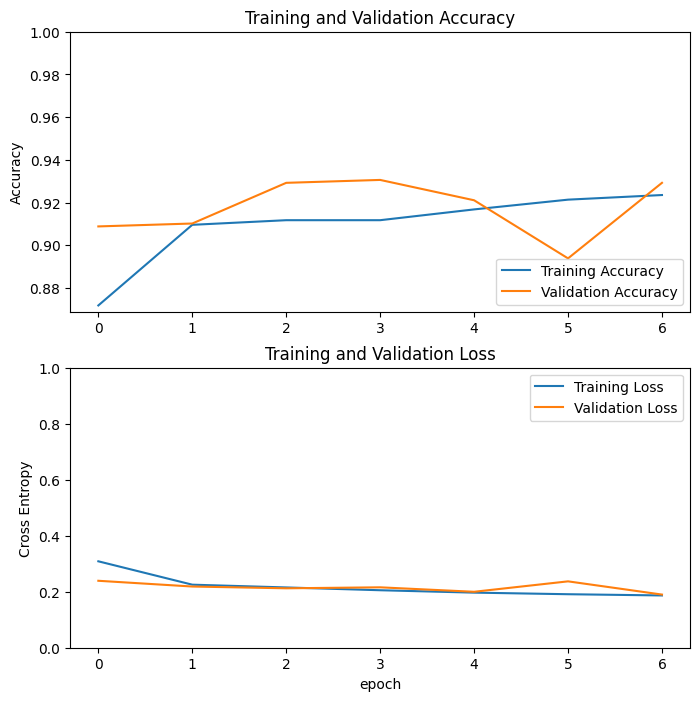

In [ ]:
# PLOTTING THE RESULTS
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# SAVING THE FINAL MODEL (BUT WE'LL USE THE BEST MODEL IDENTIFIED BY CHECKPOINT_CALLBACK)
model_2.save('last_inceptionV3_model')

# META LEARNERS
Multiple Meta Learner Algorithms were implemented to check which one best fits the non-linear relation in the predicted results by both the Base Learner models

In [14]:
# LOAD THE BEST MODELS FOR PREDICTIONS
best_model_1 = tf.keras.models.load_model('run2_best_resnet50V2_model.keras')
best_model_2 = tf.keras.models.load_model('best_inceptionV3_model.keras')

In [15]:
# STORE THE PREDICTION MADE BY THE TRAINED MODELS ON TRAIN AND VALIDATION DATASETS
train_preds_1 = best_model_1.predict(train_dataset_1)
train_preds_2 = best_model_2.predict(train_dataset_2)
val_preds_1 = best_model_1.predict(validation_dataset_1)
val_preds_2 = best_model_2.predict(validation_dataset_2)

# CREAE THE TWO FEATURE SET TO TRAIN THE META LEARNERS
stacked_train_features = np.hstack((train_preds_1, train_preds_2))
stacked_val_features = np.hstack((val_preds_1, val_preds_2))

23/23 [==============================] - 230s 7s/step


In [18]:
# STORE THE PREDICTIONS MADE BY THE TRAINED MODEL ON TEST DATASET
test_preds_1 = best_model_1.predict(test_dataset_1)
test_preds_2 = best_model_2.predict(test_dataset_2)

# CREATE THE TWO FEATURE SET TO TEST THE META LEARNERS
stacked_test_features = np.hstack((test_preds_1, test_preds_2))

27/27 [==============================] - 320s 10s/step


## META LEARNER 1: RANDOM FOREST CLASSIFIER

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# COMPILING AND TRAINING THE MODEL
meta_learner_RFC = RandomForestClassifier(n_estimators=100, random_state=42)
meta_learner_RFC.fit(stacked_train_features, y_train)

# PREDICTING ON VALIDATION DATASET
y_pred = meta_learner_RFC.predict(stacked_val_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON VALIDAION
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.5f}')

print('Classification Report:')
print(classification_report(y_val, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred))

# PREDICTING ON TEST DATASET
y_test_pred = meta_learner_RFC.predict(stacked_test_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON TEST
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy:.5f}')

print('Classification Report:')
print(classification_report(y_test, y_test_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

<ipython-input-46-eb4a1a5c5218>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  meta_learner_RFC.fit(stacked_train_features, y_train)


Accuracy: 0.77687
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       587
           1       0.26      0.06      0.10       148

    accuracy                           0.78       735
   macro avg       0.53      0.51      0.49       735
weighted avg       0.69      0.78      0.72       735

Confusion Matrix:
[[562  25]
 [139   9]]
Accuracy: 0.79977
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       715
           1       0.17      0.04      0.06       149

    accuracy                           0.80       864
   macro avg       0.50      0.50      0.48       864
weighted avg       0.71      0.80      0.75       864

Confusion Matrix:
[[685  30]
 [143   6]]


## META LEARNER 2: XGBOOST

In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# COMPILING AND TRAINING MODEL
meta_learner_XGB = XGBClassifier(random_state=42)
meta_learner_XGB.fit(stacked_train_features, y_train)

# PREDICTING ON VALIDATION DATASET
y_pred = meta_learner_XGB.predict(stacked_val_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON VALIDATION
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_val, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred))

# PREDICTING ON TEST DATASET
y_test_pred = meta_learner_XGB.predict(stacked_test_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON TEST
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy:.5f}')

print('Classification Report:')
print(classification_report(y_test, y_test_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       587
           1       0.26      0.05      0.09       148

    accuracy                           0.78       735
   macro avg       0.53      0.51      0.48       735
weighted avg       0.69      0.78      0.72       735

Confusion Matrix:
[[564  23]
 [140   8]]
Accuracy: 0.81597
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       715
           1       0.14      0.01      0.02       149

    accuracy                           0.82       864
   macro avg       0.48      0.50      0.46       864
weighted avg       0.71      0.82      0.75       864

Confusion Matrix:
[[703  12]
 [147   2]]


## META LEARNER 3: SVM with RBF kernel (For non-linearly related data classification)

In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# COMPILING AND TRAINING MODEL
meta_learner_SVC = SVC(kernel='rbf', probability=True, random_state=42)
meta_learner_SVC.fit(stacked_train_features, y_train)

# PREDICTING ON VALIDATION DATASET
y_pred = meta_learner_SVC.predict(stacked_val_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON VALIDATION
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_val, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred))

# PREDICTING ON TEST DATASET
y_test_pred = meta_learner_SVC.predict(stacked_test_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON TEST
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy:.5f}')

print('Classification Report:')
print(classification_report(y_test, y_test_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       587
           1       0.00      0.00      0.00       148

    accuracy                           0.80       735
   macro avg       0.40      0.50      0.44       735
weighted avg       0.64      0.80      0.71       735

Confusion Matrix:
[[587   0]
 [148   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.82755
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       715
           1       0.00      0.00      0.00       149

    accuracy                           0.83       864
   macro avg       0.41      0.50      0.45       864
weighted avg       0.68      0.83      0.75       864

Confusion Matrix:
[[715   0]
 [149   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## META LEARNER 4: FEED FORWARD NEURAL NETWORK

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# DEFINING THE MODEL
meta_model_nn = Sequential()
meta_model_nn.add(Dense(10, input_dim=2, activation='relu'))
meta_model_nn.add(Dense(1, activation='sigmoid'))
meta_model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# TRAINING THE MODEL
meta_model_nn.fit(stacked_train_features, y_train, epochs=5, batch_size=32, verbose=1)

# PREDICTING THE VALIDATION SET
y_pred_prob = meta_model_nn.predict(stacked_val_features)

y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# EVALUATING THE PREDICTIONS
accuracy = accuracy_score(y_val, y_pred)
classification_report_str = classification_report(y_val, y_pred)
confusion_matrix_res = confusion_matrix(y_val, y_pred)

# PRINTING THE RESULTS
print(f'Validation Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report_str)
print('Confusion Matrix:')
print(confusion_matrix_res)

Epoch 1/5
130/130 [==============================] - 1s 2ms/step - loss: 0.5726 - accuracy: 0.8180
Epoch 2/5
130/130 [==============================] - 0s 2ms/step - loss: 0.5038 - accuracy: 0.8180
Epoch 3/5
130/130 [==============================] - 0s 2ms/step - loss: 0.4885 - accuracy: 0.8180
Epoch 4/5
130/130 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.8180
Epoch 5/5
23/23 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7986394557823129
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       587
           1       0.00      0.00      0.00       148

    accuracy                           0.80       735
   macro avg       0.40      0.50      0.44       735
weighted avg       0.64      0.80      0.71       735

Confusion Matrix:
[[587   0]
 [148   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## META LEARNER 5: KNN Classifier

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# COMPILING AND TRAINING MODEL
meta_learner_KNN = KNeighborsClassifier(n_neighbors=5)
meta_learner_KNN.fit(stacked_train_features, y_train)

# PREDICTING ON VALIDATION DATASET
y_pred = meta_learner_KNN.predict(stacked_val_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON VALIDATION
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_val, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred))

y_test_pred = meta_learner_KNN.predict(stacked_test_features)

# CHECKING ACCURACY, CLASSIFICATION REPORT AND CONFUSION MATRIX ON TEST
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy:.5f}')

print('Classification Report:')
print(classification_report(y_test, y_test_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       587
           1       0.18      0.05      0.08       148

    accuracy                           0.76       735
   macro avg       0.49      0.50      0.47       735
weighted avg       0.67      0.76      0.70       735

Confusion Matrix:
[[550  37]
 [140   8]]
Accuracy: 0.80208
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       715
           1       0.23      0.06      0.10       149

    accuracy                           0.80       864
   macro avg       0.53      0.51      0.49       864
weighted avg       0.73      0.80      0.75       864

Confusion Matrix:
[[684  31]
 [140   9]]


#### Since observed results are not promising at all, let's observe the relation between predictions by base learner models

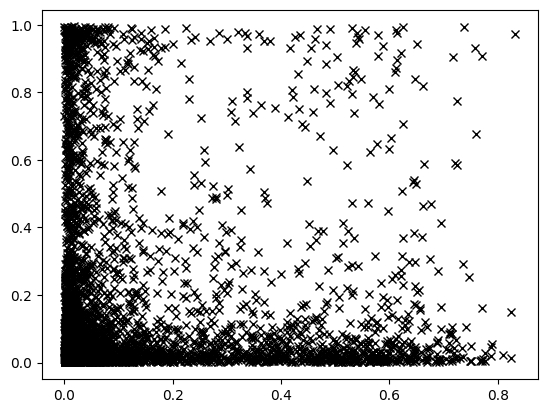

In [61]:
# SCATTER PLOT TO LOOK AT RELATIONS BETWEEN THE FEATURES (PREDICTIONS MADE FOR EACH INSTANCE BY EACH BASE LEARNER MODEL)
plt.plot(train_preds_1, train_preds_2, 'x', color = 'black')
plt.show()

#### Observed that lot of instances are predicted to be in class-0, i.e., Non-globally sclerotic

In [62]:
# CHECKING THE BINARY DISTRIBUTION OF EACH CLASS IN ALL THE TEST, VALIDATION AND TEST DATASETS
y_train_array = y_train.values.ravel()
y_val_array = y_val.values.ravel()
y_test_array = y_test.values.ravel()

print("Class distribution in y_train: ", np.bincount(y_train_array))
print("Class distribution in y_val: ", np.bincount(y_val_array))
print("Class distribution in y_test: ", np.bincount(y_test_array))

Class distribution in y_train:  [3402  757]
Class distribution in y_val:  [587 148]
Class distribution in y_test:  [715 149]


#### Since there is lot of imbalance in the class (i.e., lot of instances on class-0, and less no.of instances in class-1), the data is not providing enough variance for the Meta Learners to Learn on the predicted values. Lets use a resampling technique to populate the intances in class-1.

In [63]:
# POPULATING THE INSTANCES TO CREATE A BALANCED CLASS DISTRIBUTION IN DATA USING SMOTE RESAMPLING
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(stacked_train_features, y_train.values.ravel())

# CHECKING THE BALANCE IN TRAIN DATA
print("Class distribution in y_train_resampled: ", np.bincount(y_train_resampled))

Class distribution in y_train_resampled:  [3402 3402]


#### Now, we have a Balanced Class Distribution. Let's train best performed Meta Learner Model till now, i.e., Random Forest Classifier.

In [64]:
# PERFORMING RANDOMFORESTCLASSIFIER ON RESAMPLED DATA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# COMPILING MODEL AND TRAINING THE MODEL ON RESAMPLED DATA
meta_learner_RFC_2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
meta_learner_RFC_2.fit(X_train_resampled, y_train_resampled)

# PREDICTING THE VALIDATION SET
y_pred = meta_learner_RFC_2.predict(stacked_val_features)

# RESUTLS ON VALIDATION
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.5f}')

print('Classification Report:')
print(classification_report(y_val, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred))

# PREDICTING THE TEST SET
y_test_pred = meta_learner_RFC_2.predict(stacked_test_features)

# RESULTS ON TEST
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy:.5f}')

print('Classification Report:')
print(classification_report(y_test, y_test_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

Accuracy: 0.60408
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       587
           1       0.21      0.34      0.26       148

    accuracy                           0.60       735
   macro avg       0.50      0.50      0.49       735
weighted avg       0.68      0.60      0.63       735

Confusion Matrix:
[[394 193]
 [ 98  50]]
Accuracy: 0.61690
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.68      0.74       715
           1       0.18      0.34      0.23       149

    accuracy                           0.62       864
   macro avg       0.50      0.51      0.49       864
weighted avg       0.72      0.62      0.66       864

Confusion Matrix:
[[483 232]
 [ 99  50]]


#### Even after populating the data, the results are not enough promising than the results from the base learners. This might be because of the incapability of resampling method to recreate the variance that could be in the Real-world data.